## Background
This notebook presents an LSTM model for supervised text-classification of consumer complaints. The model takes the written complaints of financial products from US consumers and classifies the the text into various financial categories (e.g., mortgage fraud, undue fees, identity theft).

The model is based on a similar analysis I performed during an Insight Data Fellowship using proprietary data for text-classification and sentiment analysis.

The crux of the demo is a <b>Long Short Term Memory</b> (LSTM) deep-learning model using the Keras API. THis model is meant as a benchmark for another model in the sibling file XXX, which uses a more elaborate technique. 

### Analysis
In the following script, we will do the following:

+ basic NLP preprocessing
+ LSTM
+ model validation
+ hyperparameter tuning

### Data
Data is included in the 'data' directory as a large compressed .csv file from the US Consumer Financial Protection Bureau [available here](https://www.consumerfinance.gov/data-research/consumer-complaints/search/?from=0&searchField=all&searchText=&size=25&sort=created_date_desc). To save space, I keep the data as a tar xz file, and in the python code I extract it for one-time use in a tmp directory. This works on Linux/Mac, but windows users may have to manually extract the contents, and modify the script to import from where they extracted the contents. 

## Part 1: Setup and NLP

In [61]:
%matplotlib notebook
import os
import pandas as pd
import numpy as np
import re 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from keras import backend as tf
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, LSTM, RepeatVector, concatenate, Dense, Reshape, Flatten
from keras.models import Model 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix
from array import array

# set the working directory
# os.chdir(".") # generally a good practise


### Data (extraction and import)
The following decompresses the tar.xz file, calling the Unix function tar through os.system. If this doesn't work for you, just manully navigate to the data directory and decompress the .tar.xz file using whatever program you have.

In [15]:
os.system("tar xf data/complaints-2018-09-30_17_53.csv.tar.xz -C /data/")

0

In [38]:
# data file
data_dir = "data/" # I use /tmp/
fname = "complaints-2018-09-30_17_53.csv.tar.xz"
f = data_dir + fname

# read the complaint data 
d_raw = pd.read_csv(f, usecols = ['State','Complaint ID','Consumer complaint narrative','Product', 'Sub-product', 'Issue', 'Sub-issue'])
d_raw.shape # notice 191829 rows and 7 columns

# fill NaN with blanks
for col_ in ['Product','Sub-product','Issue']:
   d_raw[col_] = d_raw[col_].fillna(" ") # fill NaN with a character

print(d_raw)

The key parts of the data include:
+ Consumer complaint narrative: the text of the consumer's complaint
+ Product: highest-level of complaint categories 
+ Sub-product: 2nd-level of complaint categorization
+ Issue: 3rd-level of complaint categorization
+ Sub-Issue: ...

We will work at the level of <b>Issue</b> (which I will refer to as 'labels3'. There are over 400 sub-issues. 

The following cell combines Products and Issues, and collects all the unique categorizes. We will also <b>truncate</b> the data to exclude Issues with less than <b>10</b> representatives.

In [41]:
# factorize the two levels (Product and Product+Issue) to get unique values
d_raw['Label1'] = pd.factorize(d_raw['Product'])[0]
# combine Product + Issues
d_raw['Label3'] = pd.factorize(d_raw['Product'] + d_raw['Sub-product']+d_raw['Issue'])[0] # 570 Categories
 
# Dictionary: category integers vs. category names
cats = [pd.factorize(d_raw['Product'])[1], 
        pd.factorize(d_raw['Product'] + d_raw['Sub-product'])[1], 
        pd.factorize(d_raw['Product'] + d_raw['Sub-product']+d_raw['Issue'])[1]]

# truncate the data: only use categories with at least 10 observations
col_label = 'Label3' # columns to use for filtering
cutoff = 10 # truncation cutoff
labels_counts = d_raw.groupby([col_label]).size() # counts of Level3 categories 
which_labels = np.where(labels_counts>=cutoff)[0] # which categories have at least 'cutoff'

# make new (truncated) dataset
ixSubset = d_raw.Label3.isin(which_labels) # subset integers
# new dataset 'd', as subset of d_raw
d = (d_raw[ixSubset]).copy()

# new data set
print(d.shape) # vs d_raw.shape
print(cats)

# del d_raw


(191193, 9)


Let's visualize the distribution of categories in the data. This is a illustrative problem of the <b>'lumping & splitting' dilemma</b>: no taxonomy (ontology?) is objective, and the human generators of new categories are constantly faced with the question, do I lump together two categories into one, or do I create a new category altogether? The arbitrariness leads to an exponential increase in the number of categories over time (more categories beget more categories = exp).

Later, this will motivate the need for sample-weighting

<IPython.core.display.Javascript object>


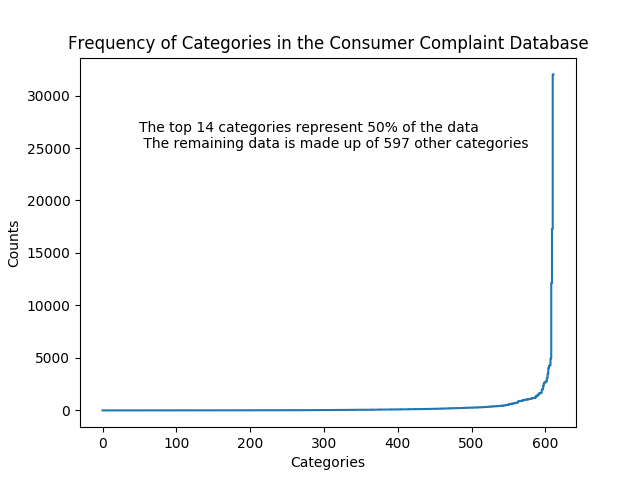

In [95]:
labels_counts.values.sort() # sort the counts of each category ('issues')
import matplotlib.pyplot as plt
# staircase plot for frequency data
plt.title('Frequency of Categories in the Consumer Complaint Database')
plt.step([i for i in range(0,len(labels_counts))], labels_counts)
plt.ylabel('Counts')
plt.xlabel('Categories')
plt.text(50,25000, "The top 14 categories represent 50% of the data\n The remaining data is made up of 597 other categories ")
plt.show()

## Clean Data:  natural language processing
We use some basic NLP techniques to prepare the data for input into the LSTM (the data is already pretty clean, otherwise, your dataset will involve a lot more, like removing non-english respondants, auto-correct):
+ remove/replace contractions (e.g., can't vs cannot)
+ remove non-alphanumeric characters
+ remove double whitespace
+ remove stop words
+ stemming (e.g., {improvement, improved} = {improv,improv}
+ cap the number of words for model

<b>WARNING: the stemming takes a long time >2 minutes </b>


In [43]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk import download as nltk_downloader 

# quick function to replace substitutions
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

 # function to do some basic NLP pre-processing steps: replacing contractions, stemming words, removing stop words
def nlp_preprocess(text_column, # column in Panda table with text
                   stop_words, # list of English stopwords
                   word_clip = 300): # truncate the number of words
   # remove contractions
   cTextl = [decontracted(x) for x in text_column.values.tolist()]
   # remove double spacing and non-alphanumeric characters
   cTextl=[re.sub(' +',' ',re.sub(r'\W+', ' ', x)) for x in cTextl]
   # lower case the words
   cTextl = [x.lower() for x in cTextl]
   # stop words and stemming
   for i in range(0,len(cTextl)):
      rawtext = cTextl[i].split(" ") # splits sentence by spaces
      rawtext = rawtext[0:min(word_clip,len(rawtext))] # take only 300 words maximum
      # stem and remove stopwords in one line (expensive operation)
      newtext = " ".join(ps.stem(word) for word in rawtext if not word in stop_words)  # loop through words, stem,join
      cTextl[i] = newtext
   return pd.DataFrame(cTextl)

# get the default English stopwords from nlkt pacakge
stop_words = set(stopwords.words('english')) # list of stopwords to remove
# get the stemming object from nltk
ps = PorterStemmer()  # stemmer

# column in data with the Text data (to feed into the LSTM)
col_text = 'Consumer complaint narrative' # name of the column with the text 

# NLP: pre-process the text/complaints
cText = nlp_preprocess(d[col_text],stop_words, word_clip = 300)

# demo: compare original text versus processed text
print("Original text: " + d[col_text][0] + "\n") #original 
print("Processed text: " + cText.iloc[0,0]) # stemmed


### Prepare Data: Vectorize text data for model-input
Having cleanned the text data, we now use the NLTK 'tokenizer' to vectorize the text into integers representing the most common 3000 words. NOTE: 'max_tokens' should be considered a type of <b>hyper-parameter</b>. More words can potentially capture more meaning, or more noise.

The matrix of token-sequence (X, below) will be the input for the word-embedding

In [53]:
# maximum number of words to consider in corpus for embedding (2000-10000 seems the general range. You should treat this like a (coarse) hyperparameter
max_tokens = 3000 
tokenizer = Tokenizer(num_words=max_tokens, split=' ')
tokenizer.fit_on_texts("STARTCODON " + cText[0])
# notice the addition of a start codon to signal to the LSTM where the sentence begins (due to the subsequent zero-padding to standardize the length of every tokenized-sentence/sequence)

# Model Input: tokenized the text data for input into word-embedding layer
X = pad_sequences(tokenizer.texts_to_sequences(("STARTCODON " + cText[0]).values)) # tokenize and pad with zeros

# number of observations/rows
n_obs = X.shape[0] 

# notice the shape: 300 tokens per complaint (standardized with zero-padding)
print(X.shape)

(191193, 301)


### Prepare Data: make categories into N-hot-coding (Y)
The response variable will be a matrix of one-hot-codings for all the different types of 'Issues'/label3 categories. In this set, there are

In [67]:
# Model Output: multinomial & multiclass labels (level 3)
Y = pd.get_dummies(d['Label3'].values) # one-hot coding

# get integers representing each (label3) class (these are the column names)
Ynames_int = Y.columns # notice the confusing mapping of different integers to different integers

# get english issue labels corresponding to each integer value in Ynames_int
Ynames_char = [cats[2][i] for i in Ynames_int] # actual names

# Finally, convert Y into a numpy matrix (not a panda df)
Y = Y.values


### Sample Weights
Due to the majority skew in representativeness of different categories, we should reduce their influence on the loss-function, and up-weight the contributions of rare categories

In [68]:
# sample weights: balancing the weights among different labels (this function only works on NON-multiclass labels, i.e., it works when there is ONE label per observation/row)
def get_class_weights(Y, # N-hot-coding response matrix
                      clip_ = 100000): # maximum weight for rarer cases
   weights_total_class_counts = (Y).sum(axis=0)
   weights_by_class = (min(weights_total_class_counts)/weights_total_class_counts) # weight by the rarest case
   Y_int = np.argmax(Y,axis=1)
   vWeights_raw = np.array([weights_by_class[i] for i in Y_int], dtype=float)
   vWeights = np.clip(vWeights_raw * (Y.shape[0]/sum(vWeights_raw)),0,clip_)
   return vWeights

vWeights = get_class_weights(Y,5) # weights


In [ ]:
### Sample sub-setting (in-sample vs out-of-sample validation)
As crude check of the out-of-sample statistics, we will split the data in 2: a training (insample) set and a test (out-of-sample) set.

In [71]:
# split the dataL set proportion for training/in-sample
fInsampleProportion = 0.5 # proportion of data for training / insample

# training and testing data
X_train, X_test,Y_train, Y_test, W_train, W_test = train_test_split(X,Y,vWeights, test_size = 1-fInsampleProportion, random_state = 99)

# one-off validation data (this is bad practise, see the cross-validatoin part)
ix_Validation = np.random.choice(X_train.shape[0],2000)
X_val = X_train[ix_Validation]
Y_val = Y_train[ix_Validation]

# Ready for the LSTM model!!!


## PART 2: LSTM Model in Keras/Tensorflow

Next, we run an Long-Short-Term model for reading the (tokenized) text data, and classifying the categories ('Issues'/label3). The core layers are:
+ word embedding (like word2vec)
+ LSTM
+ regularization
+ dense neural network

Notice the hyperparameters:
+ dim_embed_lstm: dimension of the word embedding
+ dim_out_lstm : dimension of the LSTM output
+ dim_hidden_nodes_final : number of nodes in the final hidden layer (not sor important to tune)
+ batch_size 
+ n_epochs : number of epochs

<b>Warning</b> Due to funny memory issues with Jupyter Notebooks, it is best to run tensorflow through the terminal, not within a notebook. you have been warned...

In [73]:
# Hyperparameters
dim_embed_lstm = 194 # word embedding dimension
dim_out_lstm = 150 # LSTM output dimension
dim_hidden_nodes_final = (np.linspace(dim_out_lstm,Y.shape[1]).round().astype(int))[1] # number of 

# number of epochs
n_epochs = 6
batch_size = 200

# use the Keras API to build the model
# three layers: Embedding; LSTM; Dense Hidden Layer
lstm_input_layer = Input(shape=(X_train.shape[1],), dtype='int32', name='lstm_input',) # lstm input
lstm_embed_layer = Embedding(input_dim=max_tokens, output_dim=dim_embed_lstm, input_length=X_train.shape[1])(lstm_input_layer) # input_dim = vocab size,
lstm_output = LSTM(dim_out_lstm)(lstm_embed_layer) # the output has dimension (None, 12)
hidden_layer = Dense(dim_hidden_nodes_final, activation='relu')(lstm_output)
main_output = Dense(Y_train.shape[1], activation='softmax', name='main_output')(hidden_layer) # main output for categories
model = Model(inputs=[lstm_input_layer], outputs=[main_output])
model.compile(loss = "categorical_crossentropy", optimizer='adam')
print(model.summary()) # print the model summary
model.fit({'lstm_input': X_train}, {'main_output': Y_train}, epochs = n_epochs, batch_size=batch_size, verbose = 2, sample_weight = W_train, validation_data=(X_val, Y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      (None, 301)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 301, 194)          582000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               207000    
_________________________________________________________________
dense_1 (Dense)              (None, 156)               23556     
_________________________________________________________________
main_output (Dense)          (None, 425)               66725     
Total params: 879,281
Trainable params: 879,281
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/6
 - 404s - loss: 4.0986
Epoch 2/6
 - 405s - loss: 3.6735
Epoch 3/6
 - 408s - loss: 3.3853
Epoch 4/6
 - 409s - loss: 3.2459

## Part 3 Validation: ROC/AUC scores
To validate the model, we will predict the categories on the other 1/2 of the data, and calculate the out-of-sample <b>ROC/AUC score</b>. We will do this both _globally_ and _per-category_

In [75]:
# out-of-sample data: predict the categories
pwide =  model.predict(X_test) # probability matrix

# vectorize the prediction matrix & one-hot-coding classes
pvec = pwide.flatten()
yvec = Y_test.flatten()

0.9490809500927935


Text(0.5, 23.52222222222222, 'False Positive Rate')

Global AUC score=0.949081


<IPython.core.display.Javascript object>


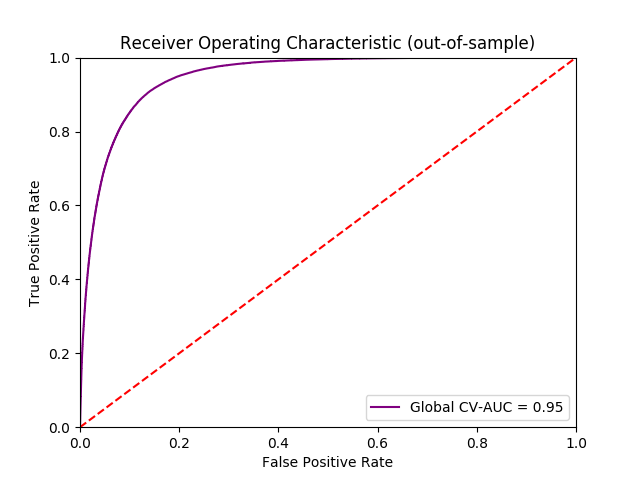

In [98]:
# calcualte fpr, tpr, and AUC scores
global_fpr, global_tpr, threshold = roc_curve(yvec, pvec)
global_roc_auc = auc(global_fpr, global_tpr) # 
print("Global AUC score=%f" % (global_roc_auc))

# plot the ROCurve
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic (out-of-sample)')
plt.plot(global_fpr, global_tpr, 'purple', label = 'Global CV-AUC = %0.2f' % global_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('img/global_roc_default_model.png')
plt.show() # to plot in your own terminal

### Validation: per-category ROC/AUC scores
Next, we will calculate the AUC scores per category. This is important because the skewed representation of different categories (less than 5% of the categorie make up about 50% of the data).

In [100]:
# calculate AUC scores per category
roc_topic = [] # container for per-category AUC scores
Y_labels_test = Y_test.argmax(axis=1)
for i in range(0,Y.shape[1]):
    tmptopic_fpr, tmptopic_tpr, threshold = roc_curve(Y_test[:,i].flatten(), pwide[:,i].flatten())
    roc_topic.append(auc(tmptopic_fpr, tmptopic_tpr))

# average ROC/AUC score overall categories
print("Average AUC (holdout) score is %f" % (sum(roc_topic)/len(roc_topic)))


Average AUC (holdout) score is 0.919945


We see that the global AUC statistic is high, dominated by the most-represented categories. However, rarer categories have worse predictive performance, and once we average _per category_, the performance drops.

Let's print the most trouble-some categories (those with poor predictive performance).

In [113]:
# get the indices of the poorest performing categories
ix_poor_topics = np.where(np.array(roc_topic)<=0.7)
print(cats[2][ix_poor_topics])


Index(['Student loanFederal student loan servicingIncorrect information on your report',
       'MortgageOther mortgageLoan servicing, payments, escrow account',
       'Payday loan, title loan, or personal loanInstallment loanProblem with the payoff process at the end of the loan',
       'Money transfer, virtual currency, or money serviceTraveler's check or cashier's checkProblem with customer service',
       'Prepaid cardMobile walletManaging, opening, or closing account',
       'Credit card or prepaid cardStore credit cardCredit monitoring or identity theft protection services'],
      dtype='object')


## Part 4: Hyperparameter Tuning

For the previous LSTM model, the hyperparameters (embedding dimension, maximum number of tokens, number of epochs) were arbitrary. In the next section, we will try to find slightly better values through k-fold cross-validation. 

TODO